In [24]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
titanic_df = pd.read_csv('train.csv')

In [26]:
def male_female_child(passenger):
    # 年齢と性別のデータを取得します。
    age,sex = passenger
    # 年齢を調べて16歳未満なら、子供。それ以外は性別をそのまま返します。
    if age < 16:
        return 3
    else:
        if sex == 'male':
            return 1
        else:
            return 2
    
# personという新しい列を追加します。
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(male_female_child,axis=1)

In [27]:
titanic_df['Alone'] = titanic_df.Parch + titanic_df.SibSp

In [28]:
titanic_df['Alone'].loc[titanic_df['Alone'] >0] = 1
titanic_df['Alone'].loc[titanic_df['Alone'] == 0] = 0

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
titanic_df['EmbarkedNo'] = titanic_df.Embarked
titanic_df['EmbarkedNo'].loc[titanic_df['EmbarkedNo'] == 'S'] = 1
titanic_df['EmbarkedNo'].loc[titanic_df['EmbarkedNo'] == 'C'] = 2
titanic_df['EmbarkedNo'].loc[titanic_df['EmbarkedNo'] == 'Q'] = 3

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Person,Alone
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.490460,0.397306
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.660838,0.489615
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,3.000000,1.000000


In [31]:
titanic_df['AgeNo'] = titanic_df['Age']
titanic_df['AgeNo'].loc[(titanic_df['AgeNo'] > 0) & (titanic_df['AgeNo'] <= 21)] = 1
titanic_df['AgeNo'].loc[(titanic_df['AgeNo'] > 21) & (titanic_df['AgeNo'] <= 28)] = 2
titanic_df['AgeNo'].loc[(titanic_df['AgeNo'] > 28) & (titanic_df['AgeNo'] <= 38)] = 3
titanic_df['AgeNo'].loc[(titanic_df['AgeNo'] > 38) & (titanic_df['AgeNo'] <= 80)] = 4

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
titanic_df['FareNo'] = titanic_df['Fare']
titanic_df['FareNo'].loc[(titanic_df['FareNo'] > 0) & (titanic_df['FareNo'] <= 7.910400)] = 1
titanic_df['FareNo'].loc[(titanic_df['FareNo'] > 7.910400) & (titanic_df['FareNo'] <= 14.454200)] = 2
titanic_df['FareNo'].loc[(titanic_df['FareNo'] > 14.454200) & (titanic_df['FareNo'] <= 31.000000)] = 3
titanic_df['FareNo'].loc[(titanic_df['FareNo'] > 31.000000) & (titanic_df['FareNo'] <= 512.329200)] = 4

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Alone,EmbarkedNo,AgeNo,FareNo
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,1,2.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,1,2,3.0,4.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,0,1,2.0,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,1,1,3.0,4.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,1,3.0,2.0


In [39]:
train_data = titanic_df.drop(['PassengerId','Name','Sex','Age','SibSp','Parch', 'Ticket','Fare', 'Cabin', 'Embarked'], 1)

In [40]:
train_data.describe()

,Survived,Pclass,Person,Alone,AgeNo,FareNo
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000
mean,0.383838,2.308642,1.490460,0.397306,2.455182,2.480359
std,0.486592,0.836071,0.660838,0.489615,1.147634,1.147741
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,1.000000,0.000000,1.000000,1.500000
50%,0.000000,3.000000,1.000000,0.000000,2.000000,2.000000
75%,1.000000,3.000000,2.000000,1.000000,3.000000,3.000000
max,1.000000,3.000000,3.000000,1.000000,4.000000,4.000000


In [41]:
train_data.head()

,Survived,Pclass,Person,Alone,EmbarkedNo,AgeNo,FareNo
0,0,3,1,1,1,2.0,1.0
1,1,1,2,1,2,3.0,4.0
2,1,3,2,0,1,2.0,2.0
3,1,1,2,1,1,3.0,4.0
4,0,3,1,0,1,3.0,2.0


In [42]:
train_data = train_data.fillna({'AgeNo':2})

In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Person        891 non-null int64
Alone         891 non-null int64
EmbarkedNo    889 non-null object
AgeNo         891 non-null float64
FareNo        891 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.8+ KB


In [44]:
train_data = train_data.fillna({'EmbarkedNo':1})
#train_data = train_data[train_data.Person != 1]

In [45]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Person        891 non-null int64
Alone         891 non-null int64
EmbarkedNo    891 non-null int64
AgeNo         891 non-null float64
FareNo        891 non-null float64
dtypes: float64(2), int64(5)
memory usage: 48.8 KB


In [46]:
t = train_data.iloc[:,0]
x = train_data.iloc[:,1:]

In [47]:
x = x.values

In [48]:
x = x.astype("f")
t = t.astype("i")

In [49]:
dataset = list(zip(x, t))

In [50]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainer
import cupy

from chainer import training
from chainer.training import extensions

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [51]:
n_train = int(len(dataset)*0.7)

In [52]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=1)

In [53]:
class NN(chainer.Chain):
    def __init__(self, n_mid_units1=3, n_out=2):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units1)
            self.fc2 = L.Linear(None, n_out)
            
            self.bn = L.BatchNormalization(6)
    
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [54]:
np.random.seed(1)
nn = NN()
model = L.Classifier(nn)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
batch_size = 10

In [55]:
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

In [56]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [64]:
epoch = 200

In [65]:
trainer = training.Trainer(updater, (epoch, "epoch"), out="result/titanic")

trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(trigger=(1, "epoch")))
trainer.extend(extensions.PrintReport(["epoch", "main/accuracy", "validation/main/accuracy", "main/loss", "validation/main/loss"]))

In [66]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss
100         0.7            0.826852                  0.627234    0.421171              
101         0.795161       0.826852                  0.458562    0.425252              
102         0.801613       0.826852                  0.435036    0.422728              
103         0.809677       0.800926                  0.437901    0.437799              
104         0.803175       0.823148                  0.453217    0.426614              
105         0.801613       0.826852                  0.457897    0.42445               
106         0.796774       0.815741                  0.465707    0.424129              
107         0.784127       0.834259                  0.451129    0.423062              
108         0.790323       0.826852                  0.446937    0.422402              
109         0.809677       0.834259                  0.452063    0.422811              
110         0.81129        0.82685

190         0.809677       0.826852                  0.437535    0.42521               
191         0.798413       0.823148                  0.461447    0.422763              
192         0.8            0.830556                  0.452938    0.425865              
193         0.795161       0.826852                  0.440093    0.431088              
194         0.807937       0.834259                  0.441654    0.427129              
195         0.812903       0.826852                  0.449385    0.420492              
196         0.8            0.834259                  0.453117    0.421225              
197         0.806349       0.834259                  0.424787    0.423139              
198         0.795161       0.830556                  0.458363    0.424529              
199         0.806452       0.826852                  0.433917    0.423872              
200         0.8            0.834259                  0.452981    0.424132              


In [67]:
import json

In [68]:
with open("result/titanic/log") as f:
    logs = json.load(f)

In [69]:
results = pd.DataFrame(logs)

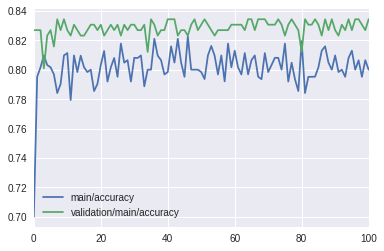

In [70]:
%matplotlib inline
results[["main/accuracy", "validation/main/accuracy"]].plot()

In [71]:
chainer.serializers.save_npz("models/titanic_3.npz", model)

In [67]:
model_man = L.Classifier(NN())
chainer.serializers.load_npz("models/titanic_man.npz", model_man)

In [69]:
model = L.Classifier(NN())
chainer.serializers.load_npz("models/titanic_2.npz", model)

In [72]:
titanic_df = pd.read_csv('test.csv')
titanic_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [73]:
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(male_female_child,axis=1)

In [74]:
titanic_df['Alone'] = titanic_df.Parch + titanic_df.SibSp

In [75]:
titanic_df['Alone'].loc[titanic_df['Alone'] >0] = 1
titanic_df['Alone'].loc[titanic_df['Alone'] == 0] = 0

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [76]:
titanic_df['EmbarkedNo'] = titanic_df.Embarked
titanic_df['EmbarkedNo'].loc[titanic_df['EmbarkedNo'] == 'S'] = 1
titanic_df['EmbarkedNo'].loc[titanic_df['EmbarkedNo'] == 'C'] = 2
titanic_df['EmbarkedNo'].loc[titanic_df['EmbarkedNo'] == 'Q'] = 3

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [77]:
titanic_df['AgeNo'] = titanic_df['Age']
titanic_df['AgeNo'].loc[(titanic_df['AgeNo'] > 0) & (titanic_df['AgeNo'] <= 21)] = 1
titanic_df['AgeNo'].loc[(titanic_df['AgeNo'] > 21) & (titanic_df['AgeNo'] <= 28)] = 2
titanic_df['AgeNo'].loc[(titanic_df['AgeNo'] > 28) & (titanic_df['AgeNo'] <= 38)] = 3
titanic_df['AgeNo'].loc[(titanic_df['AgeNo'] > 38) & (titanic_df['AgeNo'] <= 80)] = 4

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [78]:
titanic_df['FareNo'] = titanic_df['Fare']
titanic_df['FareNo'].loc[(titanic_df['FareNo'] > 0) & (titanic_df['FareNo'] <= 7.910400)] = 1
titanic_df['FareNo'].loc[(titanic_df['FareNo'] > 7.910400) & (titanic_df['FareNo'] <= 14.454200)] = 2
titanic_df['FareNo'].loc[(titanic_df['FareNo'] > 14.454200) & (titanic_df['FareNo'] <= 31.000000)] = 3
titanic_df['FareNo'].loc[(titanic_df['FareNo'] > 31.000000) & (titanic_df['FareNo'] <= 512.329200)] = 4

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [79]:
test_data = titanic_df.drop(['PassengerId','Name','Sex','Age','SibSp','Parch', 'Ticket','Fare', 'Cabin', 'Embarked'], 1)

In [80]:
test_data = test_data.fillna({'AgeNo':28})

In [81]:
test_data = test_data.fillna({'EmbarkedNo':1})
#test_data = test_data[train_data.Person == 1]

In [82]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass        418 non-null int64
Person        418 non-null int64
Alone         418 non-null int64
EmbarkedNo    418 non-null int64
AgeNo         418 non-null float64
FareNo        417 non-null float64
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


In [83]:
test_data = test_data.fillna({'FareNo':2})

In [84]:
x = test_data.values

In [85]:
x = x.astype("f")

In [86]:
survived = []

In [87]:
test_data.head()

,Pclass,Person,Alone,EmbarkedNo,AgeNo,FareNo
0,3,1,0,3,3.0,1.0
1,3,2,1,1,4.0,1.0
2,2,1,0,3,4.0,2.0
3,3,1,0,1,2.0,2.0
4,3,2,1,1,2.0,2.0


In [88]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    for i, x_ in enumerate(x):
        x_new = x_
        x_new = x_new[np.newaxis]
        '''
        if test_data['Person'].iloc[i] == 1:
            y = model_man.predictor(x_new)
        else:
             y = model.predictor(x_new)
        '''
        y = model.predictor(x_new)
        y = F.softmax(y)
        survived.append(np.argmax(y.array))

In [89]:
len(survived)

418

In [90]:
titanic_df['Survived'] = np.array(survived)

In [93]:
predict_df = titanic_df.drop(['Name','Sex','SibSp','Parch','Fare','FareNo', 'Ticket', 'Cabin', 'Embarked', 'EmbarkedNo', 'Pclass', 'Age', 'AgeNo', 'Person', 'Alone'], 1)

In [94]:
predict_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [95]:
predict_df.to_csv('predict_20181123.csv')